### Dependencies

!pip install tensorflow

pip install scikit-learn

!pip install numpy scipy matplotlib

!pip install opencv-python

## Creating Features

In [9]:
import sys
sys.path.append("../Library")

from tubecam.image_utils import load_images_labels_and_paths
from tubecam.tensorflow_utils import load_session_with_graph
from tubecam.tensorflow_utils import extract_features

images_folder = '../Resources/Pictures/Test/testset/no_google/'
frozen_graph_path = '../Training/Models/retrained_graph_5_classes_50k.pb'

#Load the images from the filesystem
images, labels, _ = load_images_labels_and_paths(images_folder)

#Extract 2048-Dim features from previously loaded images
with load_session_with_graph(frozen_graph_path) as session:
    reps = extract_features(session, images)


## t-SNE Visualisation

Codesource:  
https://github.com/oduerr/dl_tutorial/blob/master/tensorflow/inception_cifar10/Analyse_CIFAR-10_TSNE.ipynb  
and modified it a bit.

In [10]:
from tsne import bh_sne

def reps_to_tsne_data(reps):
    N = len(reps)
    Y = bh_sne(np.asarray(reps[0:N], dtype='float64'), perplexity=5)

    min_1 = Y[:,0].min()
    max_1 = Y[:,0].max()
    min_2 = Y[:,1].min()
    max_2 = Y[:,1].max()
    Yn = deepcopy(Y)
    Yn[:,0] = (Y[:,0] - min_1) / (max_1 - min_1) 
    Yn[:,1] = (Y[:,1] - min_2) / (max_2 - min_2)
    return Yn


In [11]:
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

def plot_tsne(tsne_data, labels=None, save_image=False):

    plt.figure(num=None, figsize=(10, 8))
    
    if save_image:
        save_path ='./tSNE/tSNE.jpg'
        subfolder_path = os.path.dirname(save_path)
        if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)
    
    #tSNE plot on labeled or unlabeled image
    if labels:
        #Named labels to integer labels
        indexes = np.unique(labels, return_index=True)[1]
        unique_labels = np.array([labels[index] for index in sorted(indexes)])
        labels_by_index = [np.where(unique_labels == label)[0][0] for label in labels]
        
        #labels_by_index required, as np.unique sorts before counting.
        labelcounts = np.unique(labels_by_index, return_counts=True)[1] 
        
        #Making the plot ready
        colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
        recs = []
        labelcount_start = 0
        for color, labelcount in zip(colors, labelcounts):
            recs.append(mpatches.Rectangle((0,0),1,1,fc=color))
            
            plt.plot(tsne_data[labelcount_start:labelcount_start + labelcount, 1],
                     tsne_data[labelcount_start:labelcount_start + labelcount, 0],
                     'o',
                     markersize=10,
                     markerfacecolor=color,
                     markeredgecolor='k')
            
            labelcount_start += labelcount
        lgd = plt.legend(recs, unique_labels, loc=2, bbox_to_anchor=(1.05, 1))
        if save_image:
            plt.savefig(save_path, bbox_extra_artists=(lgd,), bbox_inches='tight')
    else:
        plt.scatter(tsne_data[:, 1], tsne_data[:, 0], cmap=plt.cm.get_cmap("jet", 10), s=15, edgecolors='none')
        if save_image:
            plt.savefig(save_path)
    
    plt.show()


## Cluster it up

Codesource:  
http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py  
and modified a bit.

In [12]:
from sklearn.cluster import DBSCAN

def tsne_to_cluster(tsne_data):
    db = DBSCAN(eps=0.15, min_samples=10).fit(tsne_data)
    return db.labels_, db.core_sample_indices_


In [13]:
import numpy as np
import os

def plot_cluster(tsne_data, db_labels, core_sample_indices, save_image=False):
    n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    print('Estimated number of clusters: %d' % n_clusters)

    #Interesting for further usages
    clusters = [tsne_data[db_labels == i] for i in xrange(n_clusters)]
    outliers = tsne_data[db_labels == -1]

    core_samples_mask = np.zeros_like(db_labels, dtype=bool)
    core_samples_mask[core_sample_indices] = True

    plt.figure(num=None, figsize=(10, 8))
    # Black removed and is used for noise instead.
    unique_labels = set(db_labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    #Plot similar groups in different colors
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (db_labels == k)

        #Plot core samples
        xy = tsne_data[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14, label=k)

        #Plot non-core samples
        xy = tsne_data[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters)
    lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    if save_image:
        save_path = './tSNE/tSNE_clusters.jpg'
        subfolder_path = os.path.dirname(save_path)
        if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)
        plt.savefig(save_path, bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    plt.show()


### Plot it

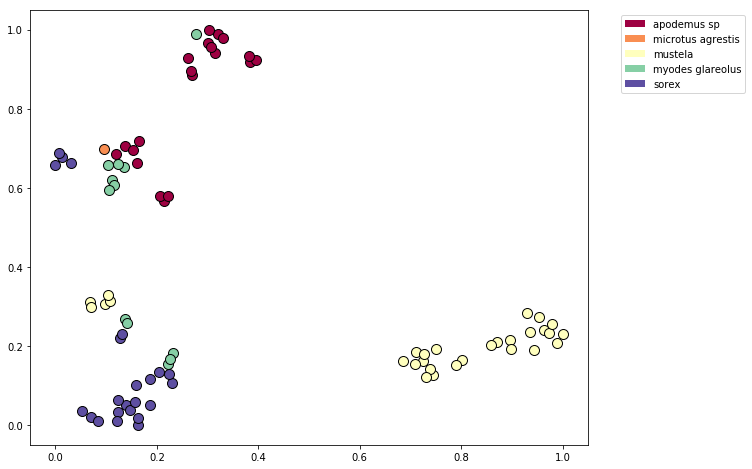

Estimated number of clusters: 4


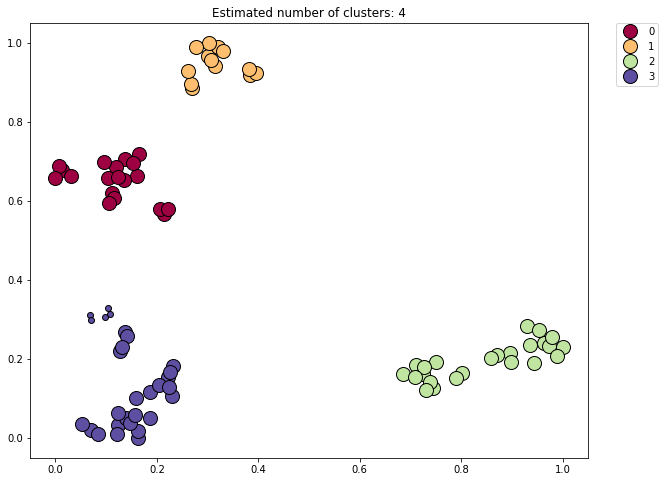

In [14]:
tsne_data = reps_to_tsne_data(reps)
plot_tsne(tsne_data, labels=labels, save_image=True)
db_labels, core_sample_indices = tsne_to_cluster(tsne_data)
plot_cluster(tsne_data, db_labels, core_sample_indices, save_image=True)


## Create Folders and save pictures

In [15]:
import sys
sys.path.append("../Library")

from tubecam.image_utils import save_images_by_label

root_path = "./tSNE/clusteredimages/"
save_images_by_label(root_path, images, db_labels)
